<a href="https://colab.research.google.com/github/Charith3800/Netflix-Stock-Price-Prediction-Using-Machine-Learning/blob/main/Netflix_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded=files.upload()

Saving NFLX.csv to NFLX.csv


In [3]:
# ---------------------------
# Netflix Stock Price Prediction Using Machine Learning
# ---------------------------

# Import libraries and set configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime

# Machine Learning & Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Time-series Model
from statsmodels.tsa.arima.model import ARIMA

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# ---------------------------
# 1. Data Loading and Preprocessing
# ---------------------------

# Load dataset
data = pd.read_csv('NFLX.csv')

# Convert 'Date' column to datetime and sort data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

print("Dataset head:")
print(data.head())

Dataset head:
        Date        Open        High         Low       Close   Adj Close  \
0 2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1 2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2 2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3 2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4 2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  


In [4]:
# ---------------------------
# 2. Feature Engineering: Technical Indicators
# ---------------------------
# 2.1 Simple Moving Average (SMA) and Exponential Moving Average (EMA)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

# 2.2 Relative Strength Index (RSI)
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period-1, adjust=False).mean()
    avg_loss = loss.ewm(com=period-1, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI_14'] = compute_RSI(data['Close'], 14)

# 2.3 Moving Average Convergence Divergence (MACD)
def compute_MACD(series, short_span=12, long_span=26, signal_span=9):
    ema_short = series.ewm(span=short_span, adjust=False).mean()
    ema_long = series.ewm(span=long_span, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal_span, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['MACD_Signal'] = compute_MACD(data['Close'])

# 2.4 Lag Features (e.g., previous day close prices)
data['Close_Lag1'] = data['Close'].shift(1)
data['Close_Lag2'] = data['Close'].shift(2)

# 2.5 Create Target Variable: next day 'Close' price
data['Target'] = data['Close'].shift(-1)

# Drop rows with NaN values from feature engineering and shifting
data = data.dropna().reset_index(drop=True)

print("\nData after feature engineering:")
print(data.head())


Data after feature engineering:
        Date        Open        High         Low       Close   Adj Close  \
0 2018-03-05  302.850006  316.910004  297.600006  315.000000  315.000000   
1 2018-03-06  319.880005  325.790009  316.500000  325.220001  325.220001   
2 2018-03-07  320.000000  323.739990  314.549988  321.160004  321.160004   
3 2018-03-08  322.200012  322.920013  314.130005  317.000000  317.000000   
4 2018-03-09  321.329987  331.440002  320.230011  331.440002  331.440002   

     Volume      SMA_20      EMA_20     RSI_14       MACD  MACD_Signal  \
0  18986100  276.568499  281.381126  89.253046  11.948521     8.630119   
1  18525800  280.116499  285.556257  90.295823  13.929635     9.690022   
2  17132200  282.888500  288.947090  86.696927  14.999173    10.751852   
3  11340100  285.510500  291.618796  83.044632  15.334347    11.668351   
4  14500200  289.577499  295.411291  85.351458  16.574107    12.649502   

   Close_Lag1  Close_Lag2      Target  
0  301.049988  290.390015

In [5]:
# ---------------------------
# 3. Data Scaling and Train-Test Split
# ---------------------------
# Define features and target variable
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
                   'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal',
                   'Close_Lag1', 'Close_Lag2']
X = data[feature_columns]
y = data['Target']

# Since it's time-series data, use sequential split (80% training, 20% testing)
train_size = int(len(data) * 0.8)
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test  = X.iloc[train_size:]
y_test  = y.iloc[train_size:]

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For the LSTM, we use the 'Close' price as our univariate series.
price_scaler = MinMaxScaler()
train_close = data['Close'].iloc[:train_size].values.reshape(-1, 1)
test_close = data['Close'].iloc[train_size:].values.reshape(-1, 1)
train_close_scaled = price_scaler.fit_transform(train_close)
test_close_scaled = price_scaler.transform(test_close)

In [6]:
# ---------------------------
# 4. Model Training and Evaluation
# ---------------------------
def evaluate_model(actual, predicted, model_name="Model"):
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    print(f"{model_name} Evaluation:")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape*100:.2f}%\n")
    return mse, rmse, mape

# 4.1 Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
print("Linear Regression Results:")
evaluate_model(y_test, lr_pred, "Linear Regression")

# 4.2 Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest Regressor Results:")
evaluate_model(y_test, rf_pred, "Random Forest")

# 4.3 XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
print("XGBoost Regressor Results:")
evaluate_model(y_test, xgb_pred, "XGBoost")

# 4.4 ARIMA Model (using the 'Close' series)
train_close_series = data['Close'].iloc[:train_size]
history = list(train_close_series)
arima_pred = []
for t in range(len(y_test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_pred.append(yhat)
    history.append(data['Close'].iloc[train_size + t])
print("ARIMA Model Results:")
evaluate_model(y_test, arima_pred, "ARIMA")

# 4.5 LSTM Model for Time-Series Forecasting
def create_sequences(data_array, look_back=60):
    X_seq, y_seq = [], []
    for i in range(len(data_array) - look_back):
        X_seq.append(data_array[i:i+look_back])
        y_seq.append(data_array[i+look_back])
    return np.array(X_seq), np.array(y_seq)

look_back = 60  # Use past 60 days to predict the next day

# Create sequences for LSTM training
X_lstm_train, y_lstm_train = create_sequences(train_close_scaled, look_back)

# For testing, we create an extended series that ensures continuity.
extended_test = np.concatenate((train_close_scaled[-look_back:], test_close_scaled))
X_lstm_test, y_lstm_test = create_sequences(extended_test, look_back)

# Build LSTM model architecture
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape inputs for LSTM: (samples, timesteps, features)
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

# Train LSTM model
history_lstm = lstm_model.fit(X_lstm_train, y_lstm_train, batch_size=16, epochs=20, validation_split=0.1, verbose=1)

# Predict with LSTM model
lstm_pred_scaled = lstm_model.predict(X_lstm_test)
lstm_pred = price_scaler.inverse_transform(lstm_pred_scaled)
y_lstm_actual = price_scaler.inverse_transform(y_lstm_test.reshape(-1, 1))

print("LSTM Model Results:")
evaluate_model(y_lstm_actual, lstm_pred, "LSTM")

Linear Regression Results:
Linear Regression Evaluation:
MSE  : 170.4188
RMSE : 13.0545
MAPE : 1.53%

Random Forest Regressor Results:
Random Forest Evaluation:
MSE  : 2907.7595
RMSE : 53.9236
MAPE : 6.01%

XGBoost Regressor Results:
XGBoost Evaluation:
MSE  : 4401.3409
RMSE : 66.3426
MAPE : 7.48%

ARIMA Model Results:
ARIMA Evaluation:
MSE  : 384.8935
RMSE : 19.6187
MAPE : 2.35%

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0590 - val_loss: 0.0109
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 8/20
42/42 ━━━━

(533.6690638817543, 23.101278403624207, 0.0306125946285976)

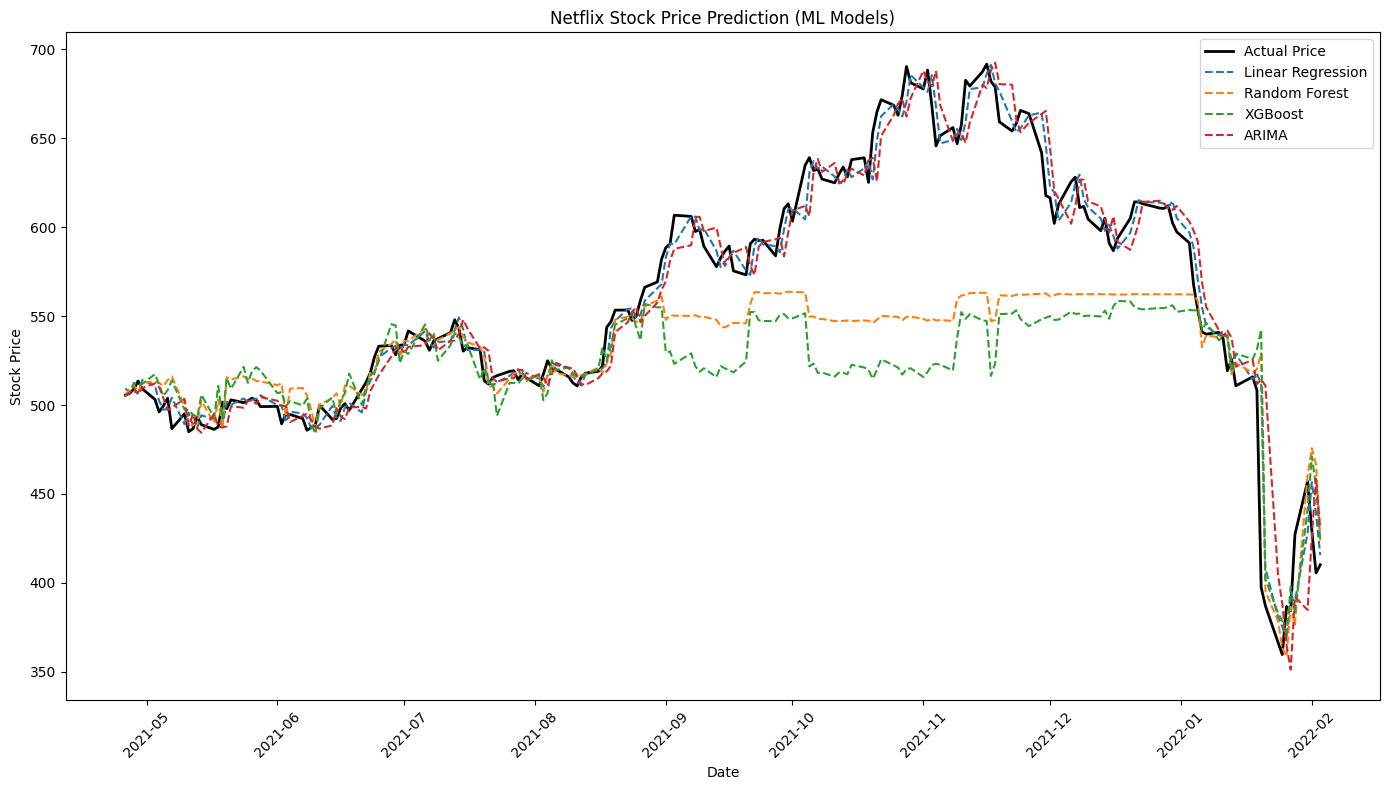

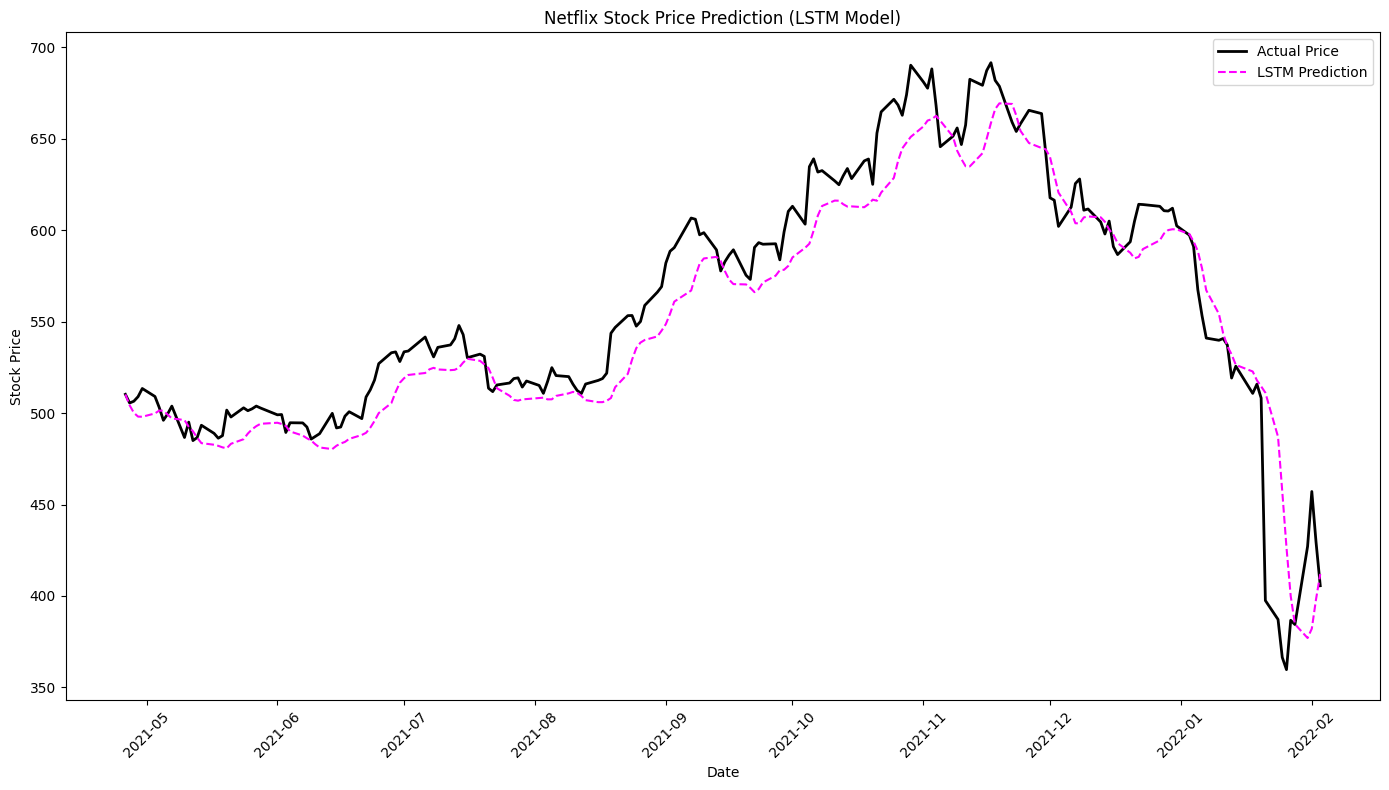

In [8]:
# ---------------------------
# 5. Visualization of Predictions
# ---------------------------
plt.figure(figsize=(14, 8))
# Plot actual vs predictions for traditional ML models
plt.plot(data['Date'].iloc[train_size:].values, y_test.values, label='Actual Price', color='black', linewidth=2)
plt.plot(data['Date'].iloc[train_size:].values, lr_pred, label='Linear Regression', linestyle='--')
plt.plot(data['Date'].iloc[train_size:].values, rf_pred, label='Random Forest', linestyle='--')
plt.plot(data['Date'].iloc[train_size:].values, xgb_pred, label='XGBoost', linestyle='--')
plt.plot(data['Date'].iloc[train_size:].values, arima_pred, label='ARIMA', linestyle='--')
plt.title("Netflix Stock Price Prediction (ML Models)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For LSTM predictions, use the dates corresponding to the test set
# (the number of predictions equals len(test_close))
lstm_dates = data['Date'].iloc[train_size:].values  # Corrected: no extra look-back offset
plt.figure(figsize=(14, 8))
plt.plot(lstm_dates, y_lstm_actual, label='Actual Price', color='black', linewidth=2)
plt.plot(lstm_dates, lstm_pred, label='LSTM Prediction', linestyle='--', color='magenta')
plt.title("Netflix Stock Price Prediction (LSTM Model)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()